## Capitalmind Coding Interview 2:

## Import Relevant Libraries

In [23]:
import io
from io import BytesIO
import requests
import json
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
from datetime import datetime
import plotly.express as px
from dateutil.relativedelta import relativedelta
from dateutil import rrule
import undetected_chromedriver as uc
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import os
import json
import extract
import seaborn as sns
import cufflinks as cf
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# To enable offline mode
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import talib as ta
import pyfolio as pf
import yfinance as yf
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')



pd.options.display.precision=4
plt.style.use('seaborn-ticks')
import warnings

warnings.filterwarnings('ignore')

## Extract NAV historical data

In [2]:
mirae = pd.read_excel("Mirae.xlsx", skiprows = 5)
icici = pd.read_excel("Icici.xlsx", skiprows = 5)
canara = pd.read_excel("Canara.xlsx", skiprows = 5)

In [3]:
mirae = mirae.reindex(index=mirae.index[::-1])
mirae = mirae.set_index('NAV Date')
mirae['1yr_rollret'] = ((mirae['NAV (Rs)']/mirae['NAV (Rs)'].shift(252)) -1)*100
mirae.tail()

,NAV (Rs),1yr_rollret
NAV Date,,
13-07-2022,72.543,0.4069
14-07-2022,72.331,0.9068
15-07-2022,72.749,1.6147
18-07-2022,73.673,2.8278
19-07-2022,73.972,2.7318


In [4]:
icici = icici.reindex(index=icici.index[::-1])
icici = icici.set_index('NAV Date')
icici['1yr_rollret'] = ((icici['NAV (Rs)']/icici['NAV (Rs)'].shift(252)) -1)*100
icici.tail()

,NAV (Rs),1yr_rollret
NAV Date,,
13-07-2022,61.35,5.0154
14-07-2022,61.22,5.6793
15-07-2022,61.57,6.3753
18-07-2022,62.48,7.9475
19-07-2022,62.66,7.2945


In [5]:
canara = canara.reindex(index=canara.index[::-1])
canara = canara.set_index('NAV Date')
canara['1yr_rollret'] = ((canara['NAV (Rs)']/canara['NAV (Rs)'].shift(252)) -1)*100
canara.tail()

,NAV (Rs),1yr_rollret
NAV Date,,
13-07-2022,37.67,-1.7987
14-07-2022,37.61,-1.1304
15-07-2022,37.89,-0.3157
18-07-2022,38.40,0.9464
19-07-2022,38.52,0.6533


In [6]:
df = pd.DataFrame(columns=['Date','Price'])

In [7]:
driver = uc.Chrome()
driver.get(f'https://in.investing.com/indices/nifty-total-returns-historical-data?end_date=1658169000&st_date=1405708200')
time.sleep(3)

In [8]:
table_trs = driver.find_elements(By.XPATH, '//*[@id="js-main-container"]/section[2]/div/section[2]/section[2]/div[1]/div/table/tbody/tr')
date = []
price = []
for i in  range(len(table_trs)):
    date.append(datetime.strptime(table_trs[i].text.split(',')[0]+" "+table_trs[i].text.split(' ')[2], '%b %d %Y').date())
    price.append(float(table_trs[i].text.split(' ')[4].replace(',','')))


In [9]:
df['Date'] = date
df['Price'] = price
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df = df.reindex(index=df.index[::-1])
df = df.set_index('Date')
df['1yr_rollret'] = ((df.Price/df.Price.shift(252)) -1)*100

In [10]:
df.index = df.index.strftime("%d-%m-20%y")

## Merge 1 YR Rolling Returns of all assets

In [11]:
data = pd.DataFrame()

In [12]:
data['Canara'] = canara['1yr_rollret']
data['ICICI'] = icici['1yr_rollret']
data['Mirae'] = mirae['1yr_rollret']
data = data.iloc[:-1,:]

In [13]:
data.tail()

,Canara,ICICI,Mirae
NAV Date,,,
12-07-2022,-1.0989,5.8036,1.1815
13-07-2022,-1.7987,5.0154,0.4069
14-07-2022,-1.1304,5.6793,0.9068
15-07-2022,-0.3157,6.3753,1.6147
18-07-2022,0.9464,7.9475,2.8278


In [14]:
idx = data.index.intersection(df.index)

In [15]:
df = df.loc[idx]
data = data.loc[idx]

In [16]:
data['NIFTY_TRI'] = df['1yr_rollret']

In [17]:
data.tail()

,Canara,ICICI,Mirae,NIFTY_TRI
12-07-2022,-1.0989,5.8036,1.1815,2.8499
13-07-2022,-1.7987,5.0154,0.4069,1.8683
14-07-2022,-1.1304,5.6793,0.9068,2.6729
15-07-2022,-0.3157,6.3753,1.6147,3.6313
18-07-2022,0.9464,7.9475,2.8278,5.0932


## Plotting the Rolling Returns and necessary shaded areas

In [18]:
data['Nifty_superior3'] =np.where((data['NIFTY_TRI']>data['Canara']) &
                                (data['NIFTY_TRI']>data['ICICI']) &
                                (data['NIFTY_TRI']>data['Mirae']),data.index,0)

In [19]:
data['Nifty_superior1'] =np.where((data['NIFTY_TRI']>data['Canara']) |
                                (data['NIFTY_TRI']>data['ICICI']) |
                                (data['NIFTY_TRI']>data['Mirae']),data.index,0)

In [20]:
xstart =[]
xend =[]
for i in range(1,df.shape[0]-1):
    if data['Nifty_superior1'].iloc[i-1] == 0 and data['Nifty_superior1'].iloc[i] != 0:
        xstart.append(data['Nifty_superior1'].iloc[i])
    if data['Nifty_superior1'].iloc[i+1] == 0 and data['Nifty_superior1'].iloc[i] != 0:
        xend.append(data['Nifty_superior1'].iloc[i])
    else:
        continue
xend.append(data['Nifty_superior1'].iloc[-1])

In [21]:
x_start =[]
x_end =[]
for i in range(1,df.shape[0]-1):
    if data['Nifty_superior3'].iloc[i-1] == 0 and data['Nifty_superior3'].iloc[i] != 0:
        x_start.append(data['Nifty_superior3'].iloc[i])
    if data['Nifty_superior3'].iloc[i+1] == 0 and data['Nifty_superior3'].iloc[i] != 0:
        x_end.append(data['Nifty_superior3'].iloc[i])
    else:
        continue
x_end.append(data[data['Nifty_superior3']!=0].iloc[-1])

In [26]:
fig = px.line(data[['Canara','ICICI','Mirae','NIFTY_TRI']])

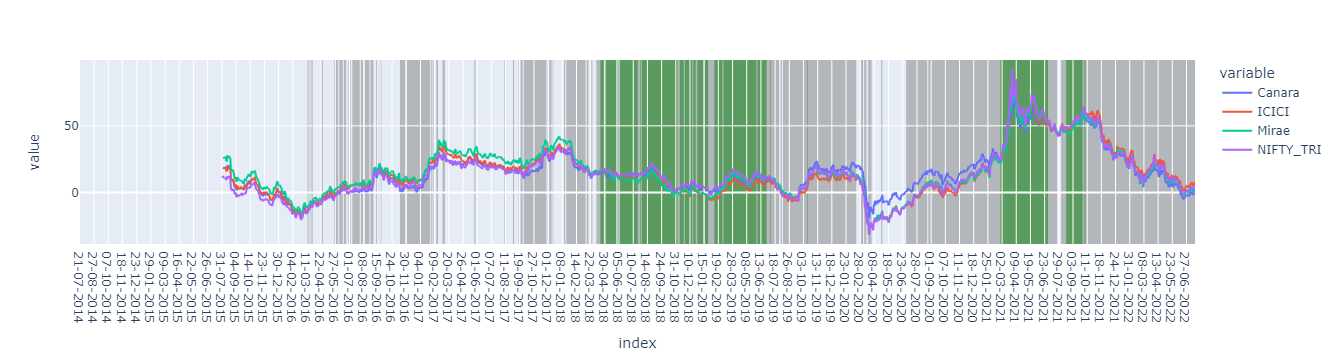

In [27]:
for i,j in zip(xstart,xend):
    fig.add_vrect(
        x0=i, x1=j,
        fillcolor="grey", opacity=0.5,
        layer="below", line_width=0
    )

for i,j in zip(x_start,x_end):
    fig.add_vrect(
        x0=i, x1=j,
        fillcolor="green", opacity=0.5,
        layer="below", line_width=0
    )
fig.show()